In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import seaborn as sns

In [2]:
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.10.0
Running on ArviZ v0.11.0


### Let's go on Kaggle to find some interesting data set!

https://www.kaggle.com/spscientist/students-performance-in-exams?select=StudentsPerformance.csv

In [3]:
df1 = pd.read_csv('data_sets/StudentsPerformance.csv')
df1.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
#check if the dataframe has nan values
df1.isnull().values.any()

False

/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


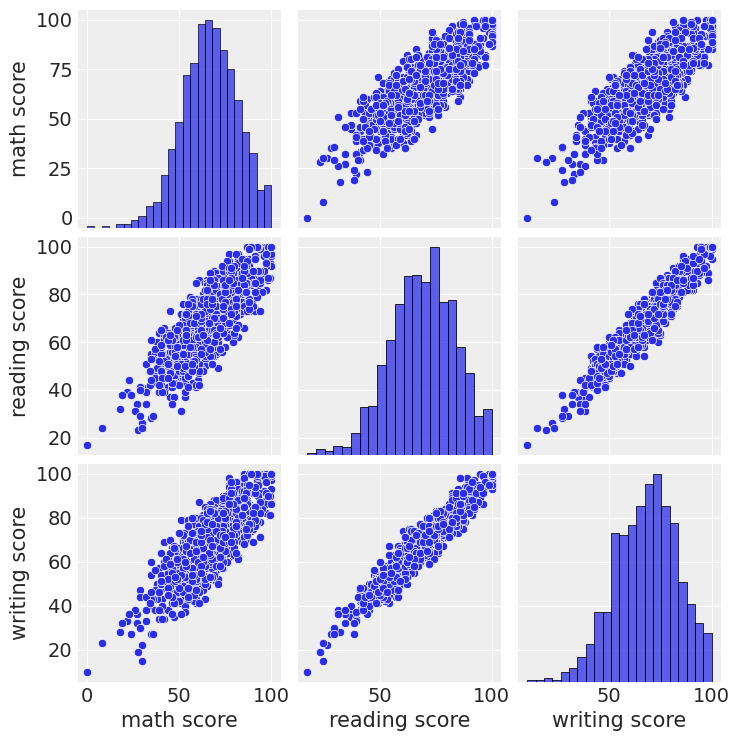

In [10]:
sns.pairplot(df1)

### Let's do a linear regression that might be of use to the insurance company! 

The insurance company does not have access to all of their customers BMI value because of ethical concerns. So they are trying to come up with a model that they can use to predict the BMI of there customers using the insurance charges they have on file. They have you for help (with considerable amount of money in return for your trouble of, of course!)

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
x = df1['charges'].values.reshape(-1,1)
y = df1['bmi'].values.reshape(-1,1)
LR =  LinearRegression()
reg =LR.fit(x,y)
print(f'Regression score {reg.score(x,y)} slope {reg.coef_} \
intercept {reg.intercept_}')

Regression score 0.03933913991786253 slope [[9.98777191e-05]] intercept [29.33797735]


Text(0.5, 0, 'Charges ($)')

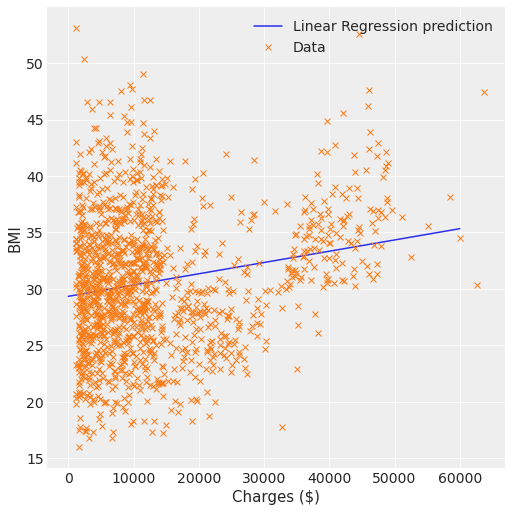

In [31]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
charge_array = np.linspace(0,60000,100).reshape(-1,1)
prediction_LR = reg.predict(charge_array)
ax.plot(charge_array, prediction_LR, label = 'Linear Regression\
 prediction')
ax.plot(x, y, 'x', label='Data')
ax.legend()
ax.set_ylabel('BMI')
ax.set_xlabel('Charges ($)')

### What would happen if the company infer the BMI from this model and make decisions based on that? 

### Uncertainty Quantification to the rescue! 

In [ ]:
with pm.Model() as model:
    # create shared variables that can be changed later on
    x_shared = pm.Data("x_obs", x)
    y_shared = pm.Data("y_obs", y)

    slope = pm.Uniform("slope",-10,10)
    intercept = pm.Uniform('intercept',0,30)
    sigma = pm.Uniform('sigma',0,10)
    obs = pm.Cauchy("obs",alpha=slope*x_shared+intercept, beta=sigma, \
              observed=y_shared)
    idata = pm.sample(draws=5000,tune=2000,\
                      return_inferencedata=True)
    #aprox =  pm.fit(n=100000, method="fullrank_advi")

In [82]:
with pm.Model() as model:
    # create shared variables that can be changed later on
    x_shared = pm.Data("x_obs", x)
    y_shared = pm.Data("y_obs", y)

    slope = pm.Uniform("slope",-10,10)
    intercept = pm.Uniform('intercept',0,30)
    sigma = pm.Uniform('sigma',0,10)
    obs = pm.Normal("obs",mu=(slope*x_shared)+intercept, sigma=sigma, \
              observed=y_shared)
    idata = pm.sample(draws=5000,tune=50000,\
                     return_inferencedata=True, step=pm.Metropolis())
    #aprox =  pm.fit(n=100000, method="fullrank_advi")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [intercept]
>Metropolis: [slope]


Sampling 4 chains for 50_000 tune and 5_000 draw iterations (200_000 + 20_000 draws total) took 58 seconds.
The number of effective samples is smaller than 10% for some parameters.


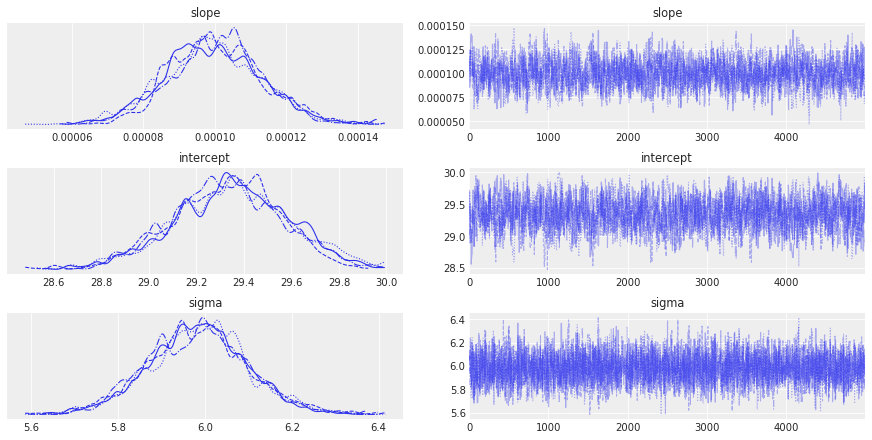

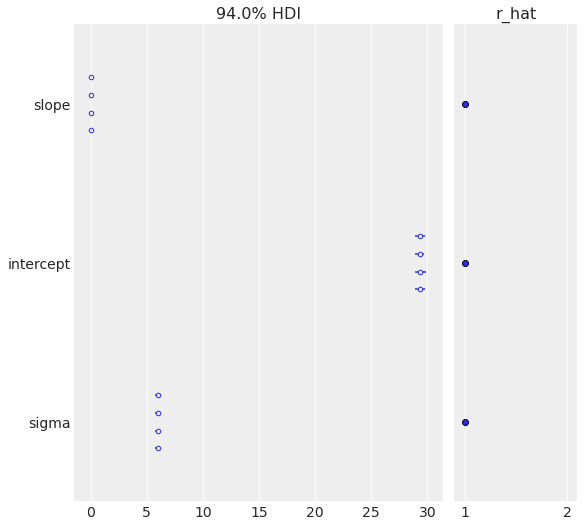

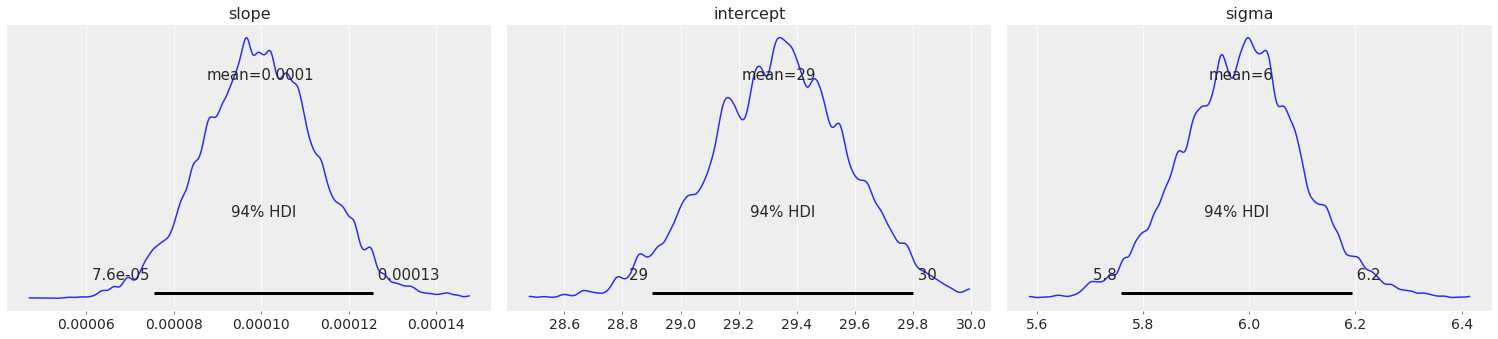

In [83]:
az.plot_trace(idata);
az.summary(idata)
az.plot_forest(idata, r_hat=True);
az.plot_posterior(idata);





In [57]:
#plt.plot(aprox.hist);

In [59]:
#plt.figure()
#trace = aprox.sample(10000, include_transformed=False)
#az.plot_kde(trace["sigma"], trace["slope"]);

In [84]:
with model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": charge_array.reshape(-1,1),
            # use dummy values with the same shape:
            "y_obs": np.zeros(100).reshape(-1,1)
        }
    )
    #post_pred = pm.sample_posterior_predictive(trace)
    post_pred = pm.sample_posterior_predictive(idata.posterior)

Text(0.5, 0, 'Charges ($)')

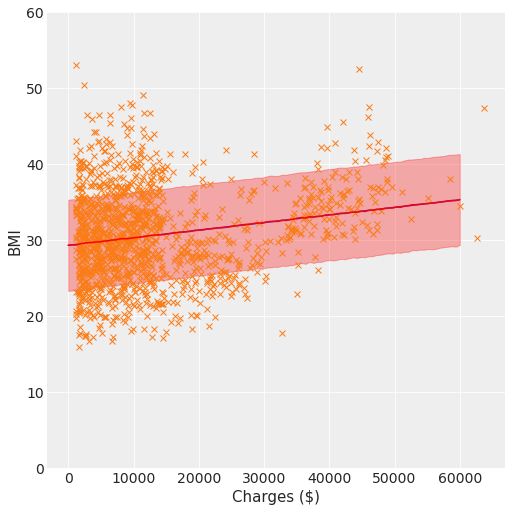

In [85]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
charge_array = np.linspace(0,60000,100).reshape(-1,1)
prediction_LR = reg.predict(charge_array)
ax.plot(charge_array, prediction_LR, label = 'Linear Regression\
 prediction')
ax.plot(x, y, 'x', label='Data')
prediction = post_pred["obs"].mean(axis=0).flatten()
prediction_er = post_pred["obs"].std(axis=0).flatten()

ax.plot(charge_array, prediction, color='red')
ax.fill_between(charge_array.flatten(), prediction-prediction_er,\
               prediction+prediction_er, color='red', alpha=0.3)
ax.set_ylim(0,60)
#ax.legend()
ax.set_ylabel('BMI')
ax.set_xlabel('Charges ($)')

# Generate Fake data

In [ ]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

# Add outliers, Let's not consider these outliers in the first step
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

#data = dict(x=x_out, y=y_out)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.plot(x,y,'x',label='sampled data')
ax.plot(x, true_regression_line, label='true line')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Genrated data and the true line')
plt.legend()


In [ ]:
with pm.Model() as model:
    mu = pm.Normal('mu',mu=0,sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed = np.random.randn(1000))
    idata = pm.sample(2000, tune=1500, return_inferencedata=True)


In [ ]:
az.plot_trace(idata);


In [ ]:
az.summary(idata)


In [ ]:
az.plot_forest(idata, r_hat=True);


In [ ]:
az.plot_posterior(idata);
